From [Medium - Graph Convolutional Networks: Introduction to GNNs](https://medium.com/data-science/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95)

In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import KarateClub
import seaborn as sns


# Import dataset from PyTorch Geometric
dataset = KarateClub()
# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

/home/emoeller/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


## Exploring The Dataset

* `x=[34, 34]` is the node feature matrix with shape (number of nodes, number of features). In our case, it means that we have 34 nodes (our 34 members), each node being associated to a 34-dim feature vector.

* `edge_index=[2, 156]` represents the graph connectivity (how the nodes are connected) with shape (2, number of directed edges).

* `y=[34]` is the node ground-truth labels. In this problem, every node is assigned to one class (group), so we have one value for each node.

* `train_mask=[34]` is an optional attribute that tells which nodes should be used for training with a list of True or False statements.

In [2]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


The node feature matrix `x` is just an identity matrix. It just stores a one-hot embedding of the nodes. In other datasets, this can contain other features like age, skill level, etc.

In [3]:
data = dataset[0]
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


The edge index contains the index positions of non-zero edges in the full node-to-node edge matrix. This allows us to keep track of which nodes are connected to one another in a form that is not as dense as a full NxN matrix.

The first list stores the source nodes, while the second list stores the destination nodes. This is also known as a **coordinate list (COO)** sparse matrix format.

In [4]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

We can use a utility to convert the adjacency martix into a dense edge matrix.

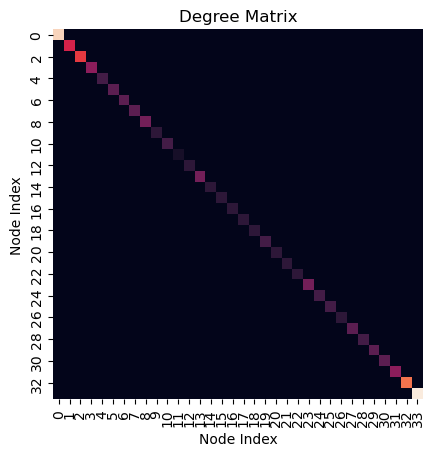

In [5]:
degree = torch.zeros(data.num_nodes, dtype=torch.int64)

src, dst = data.edge_index
degree.scatter_add_(0, src, torch.ones_like(src))
degree.scatter_add_(0, dst, torch.ones_like(dst))
D = torch.diag(degree)
sns.heatmap(D.numpy(), annot=False, cbar=False, square=True)
plt.title("Degree Matrix")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()


In [6]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


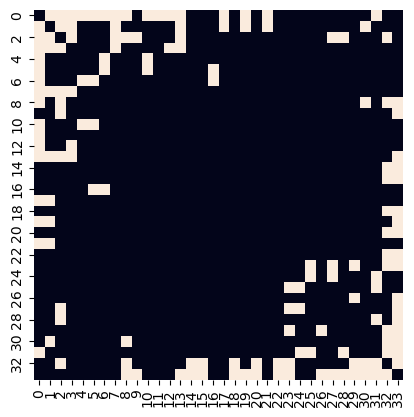

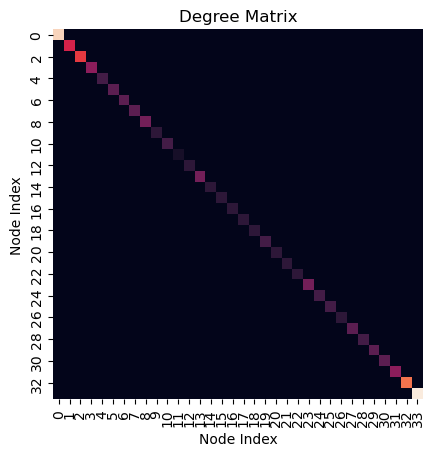

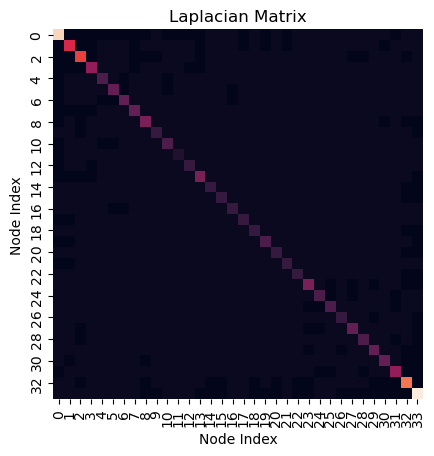

x
tensor([0.6107, 0.9580, 0.1036, 0.7009, 0.8273, 0.5344, 0.3107, 0.8133, 0.3575,
        0.9668, 0.5953, 0.0260, 0.5155, 0.7636, 0.7764, 0.2344, 0.5743, 0.7189,
        0.4381, 0.5433, 0.6660, 0.0430, 0.6752, 0.3310, 0.3388, 0.8379, 0.8016,
        0.5240, 0.9722, 0.9289, 0.1769, 0.3855, 0.7089, 0.5749])
L @ x:
tensor([11.3453, 12.7696, -5.3047,  4.6466,  3.4469,  2.1846, -0.0615,  4.1329,
         1.3999,  3.1886,  1.5994, -0.5587,  0.7503,  4.6875,  1.8218, -0.3464,
         1.4522,  1.3071,  0.4687,  1.1164,  1.3803, -1.3965,  1.4171, -0.2649,
         0.2851,  3.9724,  1.7025,  2.8441,  4.7694,  5.0152, -1.1837,  0.5829,
        11.3656,  9.2953])
x^T:
tensor([0.6107, 0.9580, 0.1036, 0.7009, 0.8273, 0.5344, 0.3107, 0.8133, 0.3575,
        0.9668, 0.5953, 0.0260, 0.5155, 0.7636, 0.7764, 0.2344, 0.5743, 0.7189,
        0.4381, 0.5433, 0.6660, 0.0430, 0.6752, 0.3310, 0.3388, 0.8379, 0.8016,
        0.5240, 0.9722, 0.9289, 0.1769, 0.3855, 0.7089, 0.5749])
Total difference across edges

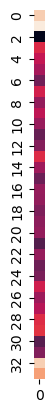

In [17]:
sns.heatmap(A, cbar=False, square=True)
plt.show()

sns.heatmap(D.numpy(), annot=False, cbar=False, square=True)
plt.title("Degree Matrix")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

# Laplacian Matrix
L = D - torch.tensor(A)
L = L.float()
sns.heatmap(L.numpy(), annot=False, cbar=False, square=True)
plt.title("Laplacian Matrix")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

x = torch.rand(data.num_nodes)
node_laplace = L @ x
print("x")
print(x)
print("L @ x:")
print(node_laplace)
sns.heatmap(node_laplace.numpy().reshape(-1,1), annot=False, cbar=False, square=True)
print("x^T:")
print(x.T)
diff = x.T @ L @ x

print("Total difference across edges:")
print(diff)

The ground truth labels in `y` simply encodes the true group number for each node (0, 1, 2, 3).

In [8]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


Finally, let's print the train mask. This shows which nodes are supposed to be used for training with `True` statements. These nodes represent the training set, while the others can be considered the test set. This helps in model evaluation by providing unseen data for testing.

In [9]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


We can also print out some useful information about the graph, such as whether it is a directed graph, it has any isolated nodes, or if any nodes have self-loops.

In [10]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


We can also convert the PyTorch Geometric graph to NetworkX using `to_networkx`

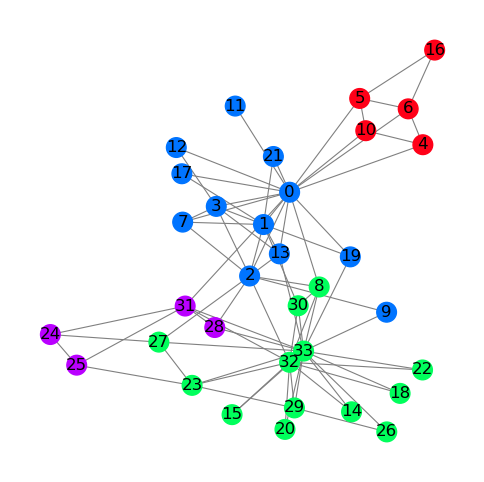

In [11]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(6,6))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=200,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=12
                )
plt.show()

## Theory - Graph Convolutional Networks

In traditional neural networks, linear layers apply a **linear transformation** to the incoming data. This transformation converts input features *x* into hidden vectors *h* through the use of a weight matrix **W**:

$$h = Wx$$

With graph data, an additional layer of complexity is added through the connections between nodes. This matters because it's assumed that similar nodes are more likely to be linked to each other compared to dissimilar ones, a phenomenon known as **network homophily**.

We can enrich our **node representation** by merging its features with those of its neighbors. This operation is called **convolution**, or neighborhood aggregation. Let's represent the neighborhood of node *i* including itself as $\tilde{\mathcal{N}}$.

$$h_{i} = \sum_{j\in\tilde{\mathcal{N}}_{i}} Wx_{j}$$

Unlike filters in CNNs, our weight matrix **W** is unique and shared among every node.

But how do we address cases where one node has only one neighbor, and another has 500? To ensure a **similar range** of values for all nodes, we can normalize the result based on the **degree** of nodes, where degree refers to the number of connections a node has.

$$h_{i} = \frac{1}{\text{deg}(i)}\sum_{j\in\tilde{\mathcal{N}}_{i}} Wx_{j}$$

The authors in Kipf et al. (2016) found one further improvement: the authors observed that features from nodes with numerous neighbors propagate much more easily than those from more isolated nodes. To offset this effect, they suggested assigning bigger weights to features from nodes with fewer neighbors, thus balancing the influence across all nodes. This operation is written as:

$$h_{i} = \sum_{j\in\tilde{\mathcal{N}}_{i}} \frac{1}{\sqrt{\text{deg}(i)}\sqrt{\text{deg}(j)}} Wx_{j}$$

Note that when *i* and *j* have the same number of neighbors, it is equivalent to our own layer.

## Implementation - Graph Convolutional Networks

PyTorch Geometric provides the `GCNConv` function, which directly implements the graph convolutional layer.

In this example, we'll create a basic Graph Convolutional Network with a single GCN layer, a ReLU activation function, and a linear output layer. This output will have **four values** corresponding to our four categories, with the highest value determining the class of each node.

In [12]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)
        
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z
    
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


If we added a second layer, our model would not only aggregate feature vectors from the neighbors of each node, but also from the neighbor of neighbors of each node.

We can **stack several graph layers** to aggregate more and more distant values, but there's a catch: if we add too many layers, the aggregation becomes so intense that all the embeddings end up looking the same. This phenomenon is called **over-smoothing** and can be a real problem when you have too many layers.

![Over Smoothing (kumo.ai/research/introduction-to-graph-transformers/)](images/over_smoothing.png)

Another limitation of GCNs is the over-squashing problem. When we aggregate messages from numerous neighbors into a single node representation, we create an information bottleneck As information is compressed through successive message passing layers, crucial information can be lost.

![Over Squashing (kumo.ai/research/introduction-to-graph-transformers/)](images/over_squashing.png)

Now that we have our GCN, let's write a simple training loop with PyTorch. I chose a regular **cross-entropy loss** since it's a multi-class classification task, with Adam as optimizer.

The training loop is standard: we try to predict the correct labels, and we compare the GCN's results to the values stored in `data.y`. The error is calculated by the cross-entropy loss and backpropagated with Adam to fine-tune our GNN's weights and biases. Finally, we print metrics every 10 epochs.

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [14]:
# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training Loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()
    
    # Forward pass
    h, z = model(data.x, data.edge_index)
    
    # Calculate loss function
    loss = criterion(z, data.y)
    
    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)
    
    # Compute gradients
    loss.backward()
    
    # Tune parameters
    optimizer.step()
    
    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    
    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%")

Epoch   0 | Loss: 1.37 | Acc: 35.29%
Epoch  10 | Loss: 1.23 | Acc: 55.88%
Epoch  20 | Loss: 0.98 | Acc: 73.53%
Epoch  30 | Loss: 0.70 | Acc: 73.53%
Epoch  40 | Loss: 0.47 | Acc: 88.24%
Epoch  50 | Loss: 0.29 | Acc: 91.18%
Epoch  60 | Loss: 0.17 | Acc: 100.00%
Epoch  70 | Loss: 0.11 | Acc: 100.00%
Epoch  80 | Loss: 0.07 | Acc: 100.00%
Epoch  90 | Loss: 0.05 | Acc: 100.00%
Epoch 100 | Loss: 0.04 | Acc: 100.00%
Epoch 110 | Loss: 0.03 | Acc: 100.00%
Epoch 120 | Loss: 0.02 | Acc: 100.00%
Epoch 130 | Loss: 0.02 | Acc: 100.00%
Epoch 140 | Loss: 0.02 | Acc: 100.00%
Epoch 150 | Loss: 0.01 | Acc: 100.00%
Epoch 160 | Loss: 0.01 | Acc: 100.00%
Epoch 170 | Loss: 0.01 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%
Epoch 200 | Loss: 0.01 | Acc: 100.00%


We can produce a neat visualization by animating the graph and see the evolution of the GNN's predictions during the training process.

In [15]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

RuntimeError: Requested MovieWriter (ffmpeg) not available

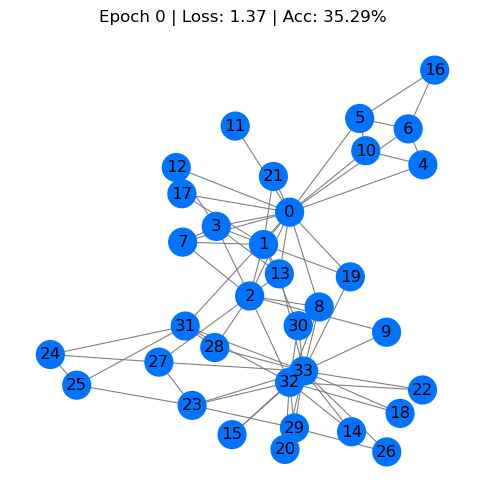

In [16]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=True,
                     node_size=400,
                     node_color=outputs[i],
                     cmap="hsv",
                     vmin=-2,
                     vmax=3,
                     width=0.8,
                     edge_color="grey",
                     font_size=12
                     )
    
    plt.title(f"Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%")

fig = plt.figure(figsize=(6,6))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

The first predictions are random, but the GCN perfectly labels every node after a while. But what does the GCN really learn?

By aggregating features from neighboring nodes, the GNN learns a vector representation (or **embedding**) of every node in the network. In our model, the final layer just learns how to use these representations to produce the best classifications. However, embeddings are the real products of GNNs.

Let's print the embeddigns learned by our model.

In [ ]:
# Print embeddings
print(f'Final Embeddings = {h.shape}')
print(h)

Final Embeddings = torch.Size([34, 3])
tensor([[9.6150e-02, 3.1303e+00, 6.6163e-02],
        [0.0000e+00, 2.5101e+00, 0.0000e+00],
        [0.0000e+00, 1.3759e+00, 0.0000e+00],
        [0.0000e+00, 2.3545e+00, 0.0000e+00],
        [1.9794e+00, 2.1652e+00, 2.1269e+00],
        [2.2492e+00, 2.4002e+00, 2.3794e+00],
        [2.2430e+00, 2.5338e+00, 2.2762e+00],
        [0.0000e+00, 1.9357e+00, 0.0000e+00],
        [0.0000e+00, 1.1607e-01, 1.4987e+00],
        [0.0000e+00, 1.3583e+00, 1.2287e-01],
        [2.0540e+00, 2.2250e+00, 2.1418e+00],
        [9.6705e-02, 1.7867e+00, 0.0000e+00],
        [0.0000e+00, 1.8387e+00, 6.8803e-02],
        [0.0000e+00, 1.7940e+00, 1.5866e-01],
        [0.0000e+00, 7.8107e-03, 1.8489e+00],
        [0.0000e+00, 9.7811e-05, 1.7092e+00],
        [2.1955e+00, 2.2474e+00, 2.3387e+00],
        [3.2779e-02, 1.9294e+00, 9.1227e-03],
        [0.0000e+00, 0.0000e+00, 1.7707e+00],
        [0.0000e+00, 1.6507e+00, 2.2142e-01],
        [0.0000e+00, 2.6204e-02, 1.8325e+

As you can see, embeddings do not have to have the same dimensions as feature vectors. Here, I chose to reduce the number of dimensions from 34 (`dataset.num_features`) to three to get a nice visualization in 3D.

Let's plot these embeddings before any training happens, at epoch 0.

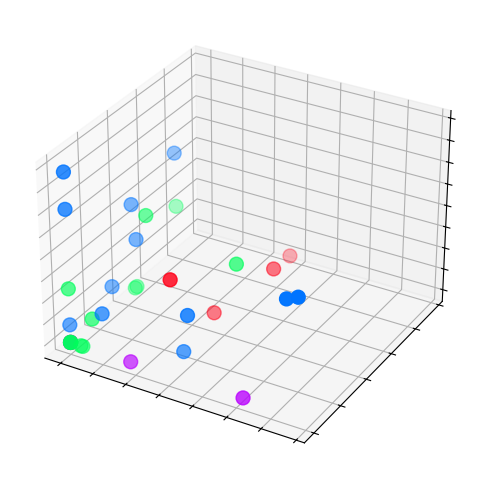

In [ ]:
# Get first embedding at epoch = 0
embed = embeddings[0].detach().cpu().numpy()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False
                )
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=100, c=data.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()

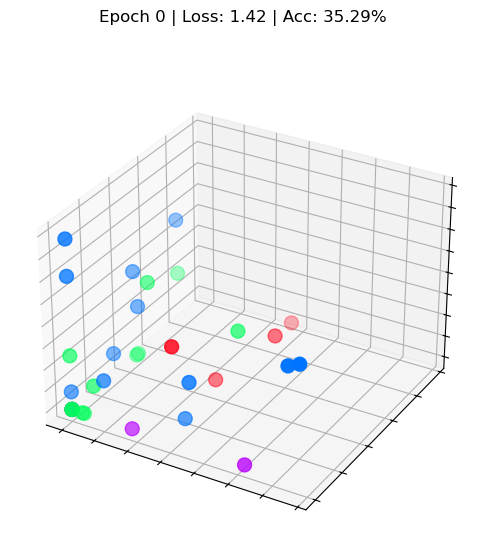

In [ ]:
def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=100, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=12, pad=40)
    
fig = plt.figure(figsize=(6, 6))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

Our Graph Convolutional Network (GCN) had effectively learned embeddings that group similar nodes into **distinct clusters**. This enables the final linear layer to distinguish them into separate classes with ease.